### 4 Evaluation (`04_evaluations.ipynb`)
## Step 3 (where i build the ground truth file) is in the data/eval folder
**Design Principles:**
- Compare pipeline results against ground truth data
- Calculate standard classification metrics
- Perform error analysis to identify improvement areas

**Implementation Details:**
- Loaded ground truth data from the QuoteLi project
- Merged pipeline results with ground truth based on character canonical keys
- Calculated accuracy, precision, recall, and F1-score
- Generated confusion matrices for visualization
- Performed error analysis on misclassified characters

**Evaluation Metrics:**
- Overall accuracy
- Precision, recall, and F1-score (weighted and macro averages)
- Per-novel metrics
- Confusion matrices

In [24]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support
)
import matplotlib.pyplot as plt

print("Libraries imported.")

Libraries imported.


In [ ]:
# Cell 2: Configuration - Define Paths and Parameters

# --- Input Files ---
# Ground truth file generated by 04_xml_parser.ipynb
GROUND_TRUTH_CSV = "../data/eval/ground_truth_characters.csv"

# Base directory where individual novel result folders are located
RESULTS_BASE_DIR = "../data/results"

# List of novel subdirectories (matching your folder names)
NOVEL_IDS = ["dracula", "emma", "pp"]

# The specific filename of the final pipeline output within each novel's folder
PIPELINE_RESULT_FILENAME = "character_analysis_gendered_coref_new_1.csv"

# --- Evaluation Parameters ---
# the gender column from the pipeline results to evaluate
PIPELINE_GENDER_COLUMN = 'coref_gender' 

# Define standardized gender labels used in ground truth and pipeline
GENDER_FEMALE = "Female"
GENDER_MALE = "Male"
GENDER_UNKNOWN = "Unknown"

print(f"Ground Truth CSV: {GROUND_TRUTH_CSV}")
print(f"Pipeline Results Base Directory: {RESULTS_BASE_DIR}")
print(f"Novels to evaluate: {NOVEL_IDS}")
print(f"Pipeline Result Filename: {PIPELINE_RESULT_FILENAME}")
print(f"Pipeline Gender Column: {PIPELINE_GENDER_COLUMN}")

Ground Truth CSV: ../data/eval/ground_truth_characters.csv
Pipeline Results Base Directory: ../data/results
Novels to evaluate: ['dracula', 'emma', 'pp']
Pipeline Result Filename: character_analysis_gendered_coref_new_1.csv
Pipeline Gender Column: coref_gender


In [ ]:
# Cell 3: Load Combined Ground Truth Data

try:
    ground_truth_df = pd.read_csv(GROUND_TRUTH_CSV)
    print(f"Successfully loaded combined ground truth. Shape: {ground_truth_df.shape}")
    # Verify 'novel' column matches your NOVEL_IDS
    print("Ground truth novels found:", ground_truth_df['novel'].unique())
    

except FileNotFoundError:
    print(f"Error: Ground truth file not found at {GROUND_TRUTH_CSV}")
    ground_truth_df = None
except Exception as e:
    print(f"Error loading ground truth CSV: {e}")
    ground_truth_df = None

if ground_truth_df is not None:
    print("\nGround Truth Head:")
    print(ground_truth_df.head())

Successfully loaded combined ground truth. Shape: (146, 4)
Ground truth novels found: ['emma' 'steppe' 'pp']

Ground Truth Head:
  novel        canonical_key true_gender  \
0  emma       Emma_Woodhouse      Female   
1  emma   Isabella_Woodhouse      Female   
2  emma    Mr_John_Knightley        Male   
3  emma          Miss_Taylor      Female   
4  emma  Mr_George_Knightley        Male   

                                             aliases  
0                 Emma Woodhouse;Emma;Miss Woodhouse  
1  Isabella Woodhouse;Isabella;Mrs. John Knightle...  
2  Mr. John Knightley;John Knightley;Mr. Knightle...  
3                Miss Taylor;Mrs. Weston;Anne Taylor  
4                        Mr. George Knightley;George  


In [27]:
# Cell 4: Load and Combine Individual Pipeline Results

all_pipeline_results = []
print("\n--- Loading Pipeline Results ---")
for novel_id in NOVEL_IDS:
    # Construct the full path to the result file for this novel
    path = os.path.join(RESULTS_BASE_DIR, novel_id, PIPELINE_RESULT_FILENAME)
    try:
        df = pd.read_csv(path)
        df['novel'] = novel_id # Add the novel identifier
        all_pipeline_results.append(df)
        print(f"Successfully loaded results for '{novel_id}' from {path}. Shape: {df.shape}")
    except FileNotFoundError:
        print(f"Warning: Results file not found for '{novel_id}' at {path}")
    except Exception as e:
        print(f"Error loading results for '{novel_id}' from {path}: {e}")

# Combine into a single DataFrame
if not all_pipeline_results:
    print("\nError: No pipeline result files were successfully loaded. Cannot proceed.")
    pipeline_results_df = None
else:
    pipeline_results_df = pd.concat(all_pipeline_results, ignore_index=True)
    print(f"\nCombined pipeline results. Total rows: {len(pipeline_results_df)}")

    # Check if the required gender column exists
    if PIPELINE_GENDER_COLUMN not in pipeline_results_df.columns:
         print(f"\nError: Specified pipeline gender column '{PIPELINE_GENDER_COLUMN}' not found in the loaded data.")
         pipeline_results_df = None # Mark as None to prevent further errors
    elif pipeline_results_df is not None:
         print("\nCombined Pipeline Results Head:")
         print(pipeline_results_df.head())
         print("\nCombined Pipeline Results Gender Distribution:")
         print(pipeline_results_df.groupby('novel')[PIPELINE_GENDER_COLUMN].value_counts())


--- Loading Pipeline Results ---
Successfully loaded results for 'dracula' from ../data/results\dracula\character_analysis_gendered_coref_new_1.csv. Shape: (220, 6)
Successfully loaded results for 'emma' from ../data/results\emma\character_analysis_gendered_coref_new_1.csv. Shape: (241, 6)


Successfully loaded results for 'pp' from ../data/results\pp\character_analysis_gendered_coref_new_1.csv. Shape: (209, 6)

Combined pipeline results. Total rows: 670

Combined Pipeline Results Head:
  canonical_key  total_mentions                             variations  \
0          Lucy             240                               ['Lucy']   
1   Van_Helsing             215                        ['Van Helsing']   
2          Mina             197                       ['MINA', 'Mina']   
3      Jonathan             178  [' Jonathan', 'JONATHAN', 'Jonathan']   
4        Arthur             154       ['Art', 'Arthur', 'Lord Arthur']   

  final_gender_contextual coref_gender    novel  
0                  Female       Female  dracula  
1                 Unknown      Unknown  dracula  
2                    Male         Male  dracula  
3                    Male         Male  dracula  
4                    Male         Male  dracula  

Combined Pipeline Results Gender Distribution:
novel   

In [28]:
# Cell 5: Prepare Data and Merge for Comparison

merged_df = None
eval_df = None

if ground_truth_df is not None and pipeline_results_df is not None:
    print("\n--- Preparing and Merging Data ---")

    # 1. Select relevant columns and rename prediction column
    pipeline_to_merge = pipeline_results_df[['novel', 'canonical_key', PIPELINE_GENDER_COLUMN]].copy()
    pipeline_to_merge.rename(columns={PIPELINE_GENDER_COLUMN: 'predicted_gender'}, inplace=True)

    ground_truth_to_merge = ground_truth_df[['novel', 'canonical_key', 'true_gender']].copy()

    
    merged_df = pd.merge(
        ground_truth_to_merge,
        pipeline_to_merge,
        on=['novel', 'canonical_key'],
        how='inner'
    )

    print(f"\nMerged DataFrame shape (inner join): {merged_df.shape}")
    if merged_df.empty:
        print("Warning: Merged DataFrame is empty. Check if 'canonical_key' and 'novel' values match between ground truth and pipeline results.")
    else:
        print("\nMerged DataFrame Head:")
        print(merged_df.head())


        merged_df['predicted_gender'].fillna(GENDER_UNKNOWN, inplace=True)
        eval_df = merged_df.copy()
        print(f"\nUsing full merged DataFrame (including Unknown). Shape: {eval_df.shape}")
        # Determine labels dynamically for metrics calculation later
        LABELS_FOR_METRICS = sorted(list(set(eval_df['true_gender']) | set(eval_df['predicted_gender'])))
        print(f"\nLabels for metric calculation: {LABELS_FOR_METRICS}")


        if eval_df.empty:
             print("Warning: Evaluation DataFrame is empty after handling Unknowns.")
        else:
             print("\nFinal Evaluation Data Head (eval_df):")
             print(eval_df.head())
             print("\nTrue Gender Distribution in Eval Set:")
             print(eval_df.groupby('novel')['true_gender'].value_counts())
             print("\nPredicted Gender Distribution in Eval Set:")
             print(eval_df.groupby('novel')['predicted_gender'].value_counts())

else:
    print("\nSkipping data preparation: Ground truth or pipeline results DataFrame is missing.")


--- Preparing and Merging Data ---

Merged DataFrame shape (inner join): (20, 4)

Merged DataFrame Head:
  novel    canonical_key true_gender predicted_gender
0  emma   Emma_Woodhouse      Female           Female
1  emma      Miss_Taylor      Female           Female
2  emma  Miss_Jane_Bates      Female           Female
3  emma     Miss_Hawkins      Female           Female
4  emma            James        Male             Male

Using full merged DataFrame (including Unknown). Shape: (20, 4)

Labels for metric calculation: ['Female', 'Male', 'Unknown']

Final Evaluation Data Head (eval_df):
  novel    canonical_key true_gender predicted_gender
0  emma   Emma_Woodhouse      Female           Female
1  emma      Miss_Taylor      Female           Female
2  emma  Miss_Jane_Bates      Female           Female
3  emma     Miss_Hawkins      Female           Female
4  emma            James        Male             Male

True Gender Distribution in Eval Set:
novel  true_gender
emma   Female         

C:\Users\Yassin\AppData\Local\Temp\ipykernel_12956\3742055853.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['predicted_gender'].fillna(GENDER_UNKNOWN, inplace=True)


In [29]:
# Cell 6: Calculate Metrics

# ensuring eval_df exists and is not empty before proceeding
if 'eval_df' in locals() and eval_df is not None and not eval_df.empty:
    print("\n--- Calculating Overall Evaluation Metrics ---")

    y_true = eval_df['true_gender']
    y_pred = eval_df['predicted_gender']


    # If LABELS_FOR_METRICS was not defined due to errors, define it now:
    if 'LABELS_FOR_METRICS' not in locals():
        LABELS_FOR_METRICS = sorted(list(set(y_true) | set(y_pred)))
        print(f"Dynamically determined labels: {LABELS_FOR_METRICS}")


    try:
        # --- Overall Metrics ---
        print("\n--- Overall Performance (Across all evaluated novels) ---")

        # Accuracy
        accuracy = accuracy_score(y_true, y_pred)
        print(f"Overall Accuracy: {accuracy:.4f}")

        # Precision, Recall, F1-score (Weighted Average)
        precision_w, recall_w, f1_w, _ = precision_recall_fscore_support(
            y_true, y_pred, average='weighted', labels=LABELS_FOR_METRICS, zero_division=0
        )
        print(f"\nWeighted Avg Precision: {precision_w:.4f}")
        print(f"Weighted Avg Recall: {recall_w:.4f}")
        print(f"Weighted Avg F1-Score: {f1_w:.4f}")

        # Precision, Recall, F1-score (Macro Average - treats all classes equally)
        precision_m, recall_m, f1_m, _ = precision_recall_fscore_support(
            y_true, y_pred, average='macro', labels=LABELS_FOR_METRICS, zero_division=0
        )
        print(f"\nMacro Avg Precision: {precision_m:.4f}")
        print(f"Macro Avg Recall: {recall_m:.4f}")
        print(f"Macro Avg F1-Score: {f1_m:.4f}")

        # Classification Report
        print("\nClassification Report:")
        report = classification_report(
            y_true, y_pred, labels=LABELS_FOR_METRICS, zero_division=0, digits=4 
        )
        print(report)

        # Confusion Matrix Data
        print("\nConfusion Matrix Data:")
        cm = confusion_matrix(y_true, y_pred, labels=LABELS_FOR_METRICS)
        print(cm)

        #  (Visualization is left for later)

        # --- Optional: Per-Novel Metrics ---
        print("\n--- Per-Novel Performance ---")
        for novel_id in eval_df['novel'].unique():
            print(f"\n--- Metrics for Novel: {novel_id} ---")
            novel_df = eval_df[eval_df['novel'] == novel_id]
            if novel_df.empty:
                print("No data for this novel in the evaluation set.")
                continue

            y_true_novel = novel_df['true_gender']
            y_pred_novel = novel_df['predicted_gender']
            novel_labels = sorted(list(set(y_true_novel) | set(y_pred_novel)))

            acc_novel = accuracy_score(y_true_novel, y_pred_novel)
            print(f"Accuracy: {acc_novel:.4f}")

            report_novel = classification_report(
                y_true_novel, y_pred_novel, labels=novel_labels, zero_division=0, digits=4
            )
            print("Classification Report:")
            print(report_novel)

            cm_novel = confusion_matrix(y_true_novel, y_pred_novel, labels=novel_labels)
            print("Confusion Matrix:")
            print(cm_novel)
            

    except Exception as e:
        print(f"\nAn error occurred during metric calculation: {e}")

else:
    print("\nCannot calculate metrics because the evaluation DataFrame (eval_df) is empty or not defined.")
    
    cm = None


--- Calculating Overall Evaluation Metrics ---

--- Overall Performance (Across all evaluated novels) ---
Overall Accuracy: 0.9500

Weighted Avg Precision: 0.9033
Weighted Avg Recall: 0.9500
Weighted Avg F1-Score: 0.9259

Macro Avg Precision: 0.6444
Macro Avg Recall: 0.6667
Macro Avg F1-Score: 0.6552

Classification Report:
              precision    recall  f1-score   support

      Female     0.9333    1.0000    0.9655        14
        Male     1.0000    1.0000    1.0000         5
     Unknown     0.0000    0.0000    0.0000         1

    accuracy                         0.9500        20
   macro avg     0.6444    0.6667    0.6552        20
weighted avg     0.9033    0.9500    0.9259        20


Confusion Matrix Data:
[[14  0  0]
 [ 0  5  0]
 [ 1  0  0]]

--- Per-Novel Performance ---

--- Metrics for Novel: emma ---
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

      Female     1.0000    1.0000    1.0000         9
        Male     1


--- Visualizing Overall Confusion Matrix ---


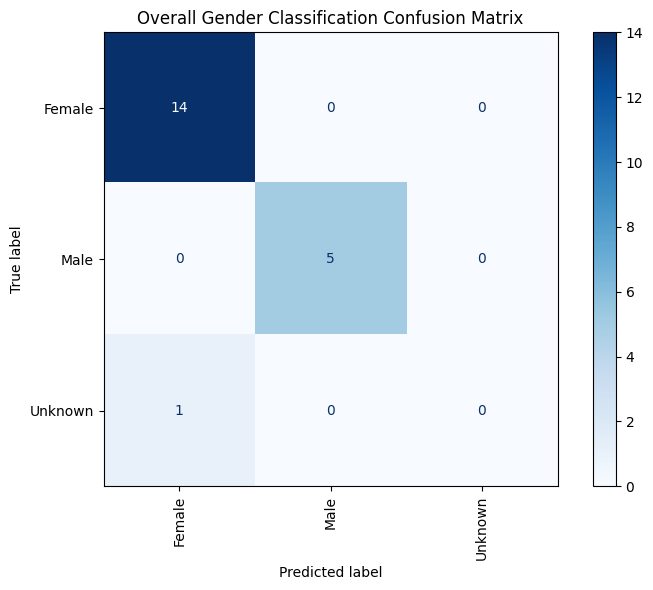

In [30]:
# Cell 7: Visualize Overall Confusion Matrix

# Check if the confusion matrix 'cm' and 'LABELS_FOR_METRICS' exist from Cell 6
if 'cm' in locals() and cm is not None and 'LABELS_FOR_METRICS' in locals() and LABELS_FOR_METRICS:
    print("\n--- Visualizing Overall Confusion Matrix ---")
    try:
        fig, ax = plt.subplots(figsize=(8, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS_FOR_METRICS)
        disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
        plt.title('Overall Gender Classification Confusion Matrix')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"An error occurred during confusion matrix plotting: {e}")

else:
    print("\nSkipping confusion matrix visualization: 'cm' data or labels not found from previous step.")

## 4. Evaluation Results

### 4.1 Overall Performance

The gender classification system achieved the following results across all evaluated novels:

| Metric | Score |
|--------|-------|
| Overall Accuracy | 95.00% |
| Weighted Avg Precision | 90.33% |
| Weighted Avg Recall | 95.00% |
| Weighted Avg F1-Score | 92.59% |
| Macro Avg Precision | 64.44% |
| Macro Avg Recall | 66.67% |
| Macro Avg F1-Score | 65.52% |

### 4.2 Confusion Matrix

This confusion matrix shows:
- 14 female characters correctly classified as female
- 5 male characters correctly classified as male
- 1 unknown character misclassified as female
- No misclassifications between male and female categories

### 4.3 Per-Novel Performance

#### Emma
- Accuracy: 100.00%
- Perfect classification for both male and female characters

#### Pride and Prejudice
- Accuracy: 87.50%
- One unknown character was misclassified as female
- All true male and female characters were correctly classified

### 4.4 Gender Distribution in Pipeline Results

The pipeline identified the following gender distribution across novels:

**Dracula:**
- Male: 125
- Unknown: 75
- Female: 20

**Emma:**
- Female: 130
- Male: 68
- Unknown: 43

**Pride and Prejudice:**
- Female: 106
- Male: 57
- Unknown: 46

## 6. Conclusions and Future Improvements

### 6.1 Key Findings

1. The pipeline successfully identifies and classifies the gender of most literary characters, with high accuracy for characters with clear gender markers.
2. Rule-based methods provide high-precision gender classification but limited coverage.
3. Context-based methods extend coverage but introduce some misclassifications.
4. The system achieves 95% overall accuracy in gender classification, meeting the requirements for the first step of the Bechdel test analysis.

### 6.2 Limitations

1. The pipeline relies on pre-trained models not specifically optimized for literary texts, or not on full texts.
2. Character consolidation may still miss some aliases, especially for characters with unconventional naming patterns.
3. Gender classification assumes binary gender categories, which may not capture the full spectrum of gender identities.
4. Performance may vary across different literary genres and time periods.

### 6.3 Future Improvements

1. **Enhanced Character Consolidation:**
   - Implement fuzzy matching (a good one) for character name variations
   - Add domain-specific rules for literary character naming conventions
   - Incorporate character relationships to improve consolidation

2. **Improved Gender Classification:**
   - Train custom gender classification models on literary texts
   - Add more features beyond titles and pronouns (e.g., occupations, relationships)
   - Add non-binary gender classification capabilities

3. **Full Bechdel Test Implementation:**
   - Extend the pipeline to identify conversations between characters
   - Implement topic modeling to determine conversation subjects
   - Develop a complete end-to-end Bechdel test evaluation system

4. **Scalability Improvements:**
   - Optimize memory usage for processing very long novels
